In [2]:
!pip install opendatasets --upgrade --quiet

#GENDER CLASSIFICATION

# 202599 Images dataset

We will be working on celebrity dataset, from many of the features provided in the dataset, we will perform for gender identification by slightly modifying ResNet 9 architecture and then perforing GAN to generate images

In [ ]:
%rm -rf celeba-dataset

Downloading the celeba-dataset from kaggle [1.33Gb size]

In [ ]:
import opendatasets as od
#

dataset_url = 'https://www.kaggle.com/jessicali9530/celeba-dataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: meenalkamalakar
Your Kaggle Key: ··········


  0%|          | 0.00/1.33G [00:00<?, ?B/s]

100%|██████████| 1.33G/1.33G [00:47<00:00, 30.0MB/s]


# Installing Important Libraries

In [ ]:
import os
import torch
import torchvision
from tqdm.notebook import tqdm
import tarfile
import shutil
import tensorflow as tf
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
DATA_DIR = './celeba-dataset'
print(os.listdir(DATA_DIR))

['list_attr_celeba.csv', 'list_bbox_celeba.csv', 'img_align_celeba', 'list_eval_partition.csv', 'list_landmarks_align_celeba.csv']


In [ ]:
print(os.listdir(DATA_DIR+'/img_align_celeba/img_align_celeba')[:10])

['117089.jpg', '103068.jpg', '197549.jpg', '096101.jpg', '122269.jpg', '094478.jpg', '159511.jpg', '042434.jpg', '079118.jpg', '015575.jpg']


In [ ]:
project_name='genderdet-resnet9-gan'

List_attr_celeba.csv contains a total of 41 attributes:columns of celebrities from which we are intrested in the image_id and male(gender)

In [ ]:
df_attr = pd.read_csv(DATA_DIR + '/list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df_attr.shape
df_attr.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000001.jpg,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1
000002.jpg,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
000003.jpg,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
000004.jpg,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,1
000005.jpg,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1


In [ ]:
#checking attributes
for i, j in enumerate(df_attr.columns):
    print(i, j)

0 5_o_Clock_Shadow
1 Arched_Eyebrows
2 Attractive
3 Bags_Under_Eyes
4 Bald
5 Bangs
6 Big_Lips
7 Big_Nose
8 Black_Hair
9 Blond_Hair
10 Blurry
11 Brown_Hair
12 Bushy_Eyebrows
13 Chubby
14 Double_Chin
15 Eyeglasses
16 Goatee
17 Gray_Hair
18 Heavy_Makeup
19 High_Cheekbones
20 Male
21 Mouth_Slightly_Open
22 Mustache
23 Narrow_Eyes
24 No_Beard
25 Oval_Face
26 Pale_Skin
27 Pointy_Nose
28 Receding_Hairline
29 Rosy_Cheeks
30 Sideburns
31 Smiling
32 Straight_Hair
33 Wavy_Hair
34 Wearing_Earrings
35 Wearing_Hat
36 Wearing_Lipstick
37 Wearing_Necklace
38 Wearing_Necktie
39 Young


## DATA VISUALIZATION

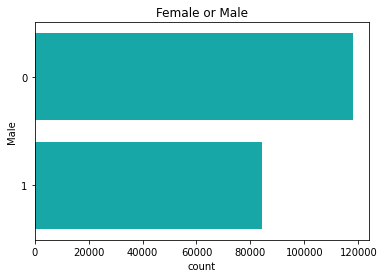

In [ ]:
#detection graph
import seaborn as sns
plt.title('Female or Male')
sns.countplot(y='Male', data=df_attr, color="c")
plt.show()

list_eval_partition.csv provides a effective partition of dataset for training, validation and testing. This information is inculcated into data extraction

In [ ]:
df_partition = pd.read_csv(DATA_DIR + '/list_eval_partition.csv')
df_partition['image']=df_partition['image_id'].astype(str)
df_partition.head()


,image_id,partition,image
0,000001.jpg,0,000001.jpg
1,000002.jpg,0,000002.jpg
2,000003.jpg,0,000003.jpg
3,000004.jpg,0,000004.jpg
4,000005.jpg,0,000005.jpg


In [ ]:
df_partition['partition'].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

In [ ]:
df_attr['Male']

image_id
000001.jpg    0
000002.jpg    0
000003.jpg    1
000004.jpg    0
000005.jpg    0
             ..
202595.jpg    0
202596.jpg    1
202597.jpg    1
202598.jpg    0
202599.jpg    0
Name: Male, Length: 202599, dtype: int64

MERGING OF IMAGE_ID,PARTITION AND MALE COLUMNS 

In [ ]:
df_partition.set_index('image_id', inplace=True)
#df_par_attr = pd.concat(df_partition,df_attr['Male'])
df_par_attr =df_partition.join(df_attr['Male'], how='inner')
df_par_attr.head()

,partition,image,Male
image_id,,,
000001.jpg,0,000001.jpg,0
000002.jpg,0,000002.jpg,0
000003.jpg,0,000003.jpg,1
000004.jpg,0,000004.jpg,0
000005.jpg,0,000005.jpg,0


# CREATING FOLDERS
test
train
val
all these folders have *male* and *female* subdirectory

In [ ]:
os.makedirs(DATA_DIR+'/img_align_celeba/train/male')
os.makedirs(DATA_DIR+'/img_align_celeba/train/female')
os.makedirs(DATA_DIR+'/img_align_celeba/test/male')
os.makedirs(DATA_DIR+'/img_align_celeba/test/female')
os.makedirs(DATA_DIR+'/img_align_celeba/val/male')
os.makedirs(DATA_DIR+'/img_align_celeba/val/female')
source=DATA_DIR+'/img_align_celeba/img_align_celeba/'
destination=DATA_DIR+'/img_align_celeba/'


In [ ]:
df_par_attr['image']

image_id
000001.jpg    000001.jpg
000002.jpg    000002.jpg
000003.jpg    000003.jpg
000004.jpg    000004.jpg
000005.jpg    000005.jpg
                 ...    
202595.jpg    202595.jpg
202596.jpg    202596.jpg
202597.jpg    202597.jpg
202598.jpg    202598.jpg
202599.jpg    202599.jpg
Name: image, Length: 202599, dtype: object

In [ ]:
from PIL import Image
from numpy import asarray 
  
def check_male(a):
  if a==1:
    return "male/"
  else:
    return "female/"

In [ ]:
#R=np.zeros((218,178))
#G=np.zeros((218,178))
#B=np.zeros((218,178))

#    '''
 #   partition
  #      0 -> train
#        1 -> validation
#        2 -> test

for ind in df_par_attr.index: 
      if df_par_attr['partition'][ind]==0:
          #I=Image.open(source+str(df_par_attr['image'][ind]))
          #Inu = numpy.array(I)#[indices.astype(int)]
          #Inu=numpy.reshape(Inu,(3,218,178))
          #Inu= DeviceDataLoader(Inu, device)
          #I=numpy.concatenate((I,Inu[0]))
          #if i%100==0:
           # print(i/100)
        #shutil.move(source+str(df_par_attr['image'][ind]), destination+'train')
          os.rename(source+str(df_par_attr['image'][ind]),destination+'train/'+check_male(df_par_attr['Male'][ind])+str(ind)) 
       #os.rename(destination+'train/'+str(df_par_attr['image'][ind]),destination+'train/'+check_male(df_par_attr['Male'][ind])+str(ind)) 
      if df_par_attr['partition'][ind]==1:
       #shutil.move(source+str(df_par_attr['image'][ind]), destination+'val')
          os.rename(source+str(df_par_attr['image'][ind]),destination+'val/'+check_male(df_par_attr['Male'][ind])+str(ind)) 
      if df_par_attr['partition'][ind]==2:  
       #shutil.move(source+str(df_par_attr['image'][ind]), destination+'test')
          os.rename(source+str(df_par_attr['image'][ind]),destination+'test/'+check_male(df_par_attr['Male'][ind])+str(ind)) 
   

finding the stats from CPU takes around 2.5hours+ with invlid result, so 
creating a dataloader of training data set which isnt normalized into GPU AND Calculation of
stats


# GPU setup and Dataloaders

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

since I already went on finding the training images mean and std, if you wish to try you need to comment in the *stats tuple* and rr.normalize(*stats)  to form unnormalized dataset and running the *norm_im* function ahead to get the mentioned stats

In [ ]:
image_size = 128
batch_size = 32
#stats founded by having unnormalized training set onto dataloader and running mentioned function:
#norm_im(train_dl_unnormalized)
stats=((0.5081, 0.4220, 0.3765),(0.2629, 0.2404, 0.2380))

In [ ]:
train_tfms = tt.Compose([tt.RandomCrop(image_size, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])


In [ ]:
# PyTorch datasets
train_ds = ImageFolder(destination+'/train', train_tfms)
valid_ds = ImageFolder(destination+'/val', valid_tfms)

In [ ]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)


In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

#using norm_im for the unnormalized training data to get 
#mean: tensor([0.5081, 0.4220, 0.3765], device='cuda:0')
#std:  tensor([0.2629, 0.2404, 0.2380], device='cuda:0')
def norm_im(dl):
    nimages = 0
    mean = 0.
    std = 0.
    var=0.
    for i_batch, batch_target in enumerate(dl):
        batch = batch_target[0]
        # Rearrange batch to be the shape of [B, C, W * H]
        batch = batch.view(batch.size(0), batch.size(1), -1)
        # Update total number of images
        nimages += batch.size(0)
        # Compute mean and std here
        mean += batch.mean(2).sum(0) 
        var += batch.var(2).sum(0)

    mean /= nimages
    var /= nimages
    std = torch.sqrt(var)

    print(mean)
    print(std)

def show_batch(dl):
    i=1
    for images, labels in dl:
        if i==1:
          print(images.shape)
          print(images.dtype)
          print(labels.shape)
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        i=2
        break

torch.Size([32, 3, 128, 128])
torch.float32
torch.Size([32])


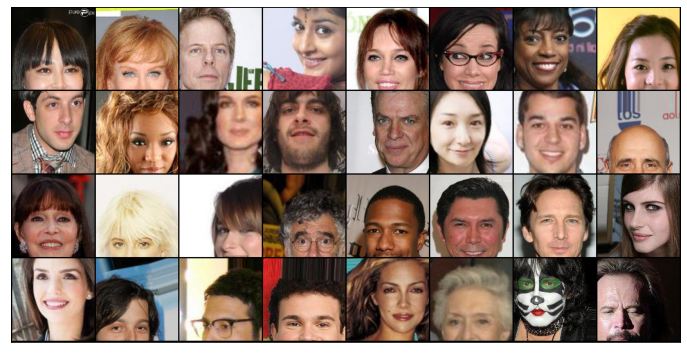

In [ ]:
show_batch(train_dl)

In [ ]:
#GPU Loading data
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

Uncoment this for unnormalized training dataloaders

In [ ]:
#norm_im(train_dl)   #for unnormalized dl

# Image preview

In [ ]:
img = load_img(destination+'test/male/182643.jpg')

In [ ]:
from PIL import Image

def open_image(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [ ]:
I=open_image(destination+'test/male/182643.jpg')

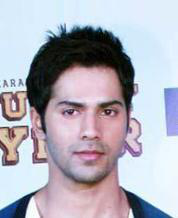

In [ ]:
I

# CREATING RESIDUAL BLOCK AND RESNET9 ARCHITECTURE

In [ ]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x

In [ ]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break
    
del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([32, 3, 128, 128])


In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))#4=>2-orig
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()    #128
        
        self.conv1 = conv_block(in_channels, 64)    #64x128x128
        self.conv2 = conv_block(64, 128, pool=True) #128x64x64  
        self.conv22 = conv_block(128, 128, pool=True) #128x32x32  
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128)) #128
        
        self.conv3 = conv_block(128, 256, pool=True) #256x16x16
        self.conv4 = conv_block(256, 512, pool=True) #512x8x8
        self.conv44 = conv_block(512, 512, pool=True) #512x4x4  
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes,bias=True))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.conv22(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv44(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3, 2), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv22): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, 

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.5732013583183289, 'val_loss': 0.6923230290412903}]

In [ ]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00280, train_loss: 0.2005, val_loss: 0.1214, val_acc: 0.9522
Epoch [1], last_lr: 0.00760, train_loss: 0.1564, val_loss: 0.0953, val_acc: 0.9642
Epoch [2], last_lr: 0.01000, train_loss: 0.1469, val_loss: 0.1010, val_acc: 0.9610
Epoch [3], last_lr: 0.00950, train_loss: 0.1440, val_loss: 0.3432, val_acc: 0.8721
Epoch [4], last_lr: 0.00812, train_loss: 0.1397, val_loss: 0.1017, val_acc: 0.9664
Epoch [5], last_lr: 0.00611, train_loss: 0.1277, val_loss: 0.0852, val_acc: 0.9662
Epoch [6], last_lr: 0.00389, train_loss: 0.1151, val_loss: 0.0715, val_acc: 0.9742
Epoch [7], last_lr: 0.00188, train_loss: 0.1023, val_loss: 0.0627, val_acc: 0.9757
Epoch [8], last_lr: 0.00050, train_loss: 0.0902, val_loss: 0.0549, val_acc: 0.9797
Epoch [9], last_lr: 0.00000, train_loss: 0.0803, val_loss: 0.0530, val_acc: 0.9817
CPU times: user 1h 15min 32s, sys: 54min 26s, total: 2h 9min 59s
Wall time: 2h 8min 52s


**With wall time of 2 hours 8 mins, 10 epochs: we get an accuracy of 98%**

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

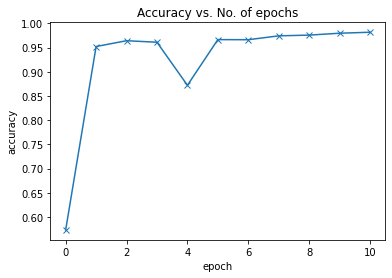

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

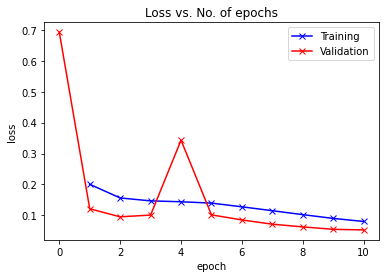

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

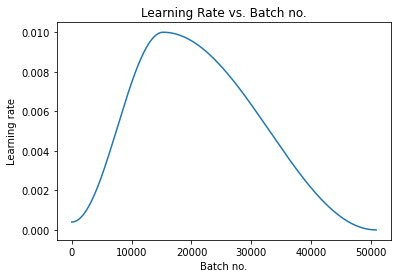

In [ ]:
plot_lrs(history)

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

In [ ]:
test_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])
test_ds = ImageFolder(destination+'/test', valid_tfms)
#test_dl = DataLoader(test_ds, batch_size*2, num_workers=3, pin_memory=True)
#test_dl = DeviceDataLoader(test_dl, device)


Testing with individual image

Label: female , Predicted: female


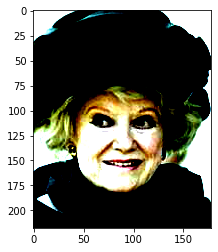

In [ ]:
img, label = test_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
train_time='2hr'